# Get individual leaves

Now that we have individual pots, we need to identify individual leaves

**Currently stuck at trying to get _every_ leaf tip, to then run a watershed segmentation**

In [1]:
import tifffile as tf
import numpy as np
import pandas as pd

import glob
import numpy.polynomial.polynomial as P
import scipy.spatial as spatial
import scipy.ndimage as ndimage
from importlib import reload

import arabidopsis_utils as thales
import MinimumBoundingBox as mbb

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [2]:
reload(thales)

<module 'arabidopsis_utils' from '/home/ejam/documents/arabidopsis_scanning/jupyter/arabidopsis_utils.py'>

In [3]:
tiff_file = '../raw3d/u112-3.tif'
pot_src = '../pots/'

_, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]

src = pot_src + bname + '/'

In [4]:
raw = tf.imread(src + 'airless.tif')

In [5]:
potfiles = sorted(glob.glob(src + bname + '_pot*.tif'))

potfiles

['../pots/u112-3/u112-3_pot0.tif',
 '../pots/u112-3/u112-3_pot1.tif',
 '../pots/u112-3/u112-3_pot2.tif',
 '../pots/u112-3/u112-3_pot3.tif']

In [6]:
pot = [None for i in range(len(potfiles))]

for i in range(len(pot)):
    pot[i] = tf.imread(potfiles[i])
    print(np.sum(pot[i] > 0))

5259969
10901159
9651610
5556942


In [8]:
pidx = 2
timg = pot[pidx].copy()
timg, ceros, cerosshape = thales.clean_zeroes(timg)

print(np.max(timg))

81 % reduction from input
142


In [9]:
leaf_dst = '../leaves/'
dst = leaf_dst + bname + '/' + 'pot{}/'.format(pidx)
if not os.path.isdir(dst):
    os.makedirs(dst)
print('All results will be saved in ', dst)

All results will be saved in  ../leaves/u112-3/pot2/


In [10]:
rawp = raw[ceros].reshape(cerosshape)

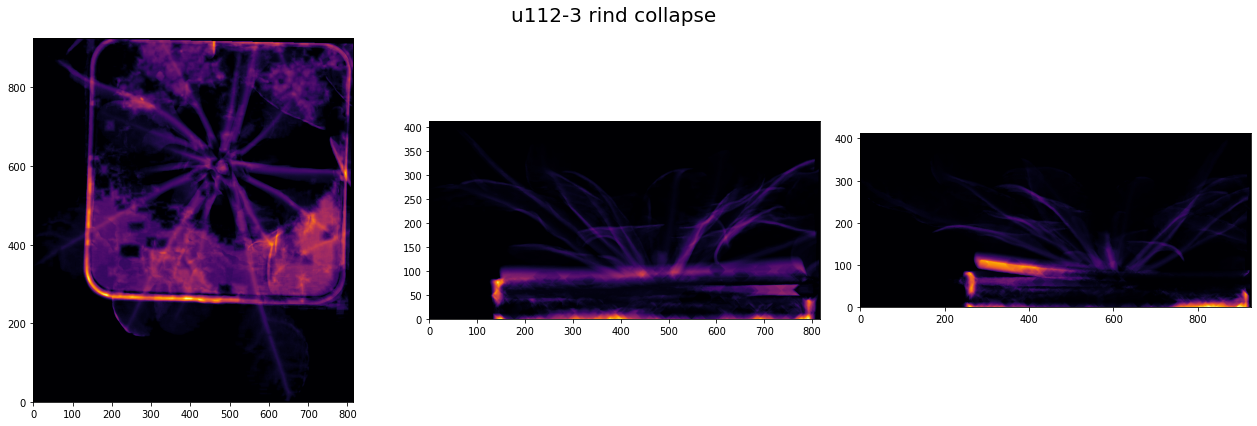

In [11]:
writefig = False
display  = True
diag_dst = src
snaps = thales.collapse_dimensions(timg)
thales.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=writefig, dst=diag_dst)

# Separate connected components

Find where the soil ends.

- Count the number of nonzero voxels per slice.
- We should see a drop past the soil level.

In [13]:
bpot = timg.copy()
bpot[bpot > 0] = 1
levels = np.sum(bpot, axis=(1,2), dtype=int)
diff = np.ediff1d(levels)

In [14]:
import unionfind as UF

pers = sorted(UF.persistence(levels),reverse=True)
print(pers)

[(inf, None, 0), (74782, 24, 94), (20694, 72, 67), (10186, 47, 40), (9838, 157, 190), (1883, 142, 152), (1627, 196, 201), (1261, 230, 239), (1026, 33, 29), (958, 220, 225), (821, 263, 271), (776, 292, 303), (392, 175, 172), (390, 248, 252), (379, 278, 281), (313, 235, 233), (266, 282, 286), (236, 299, 296), (219, 317, 321), (204, 265, 264), (150, 184, 183), (114, 182, 181), (97, 148, 147), (85, 319, 318), (85, 137, 138), (42, 269, 268), (41, 207, 208), (34, 186, 185), (24, 378, 384), (18, 301, 300), (16, 251, 250), (15, 370, 371), (14, 394, 395), (14, 146, 145), (12, 341, 342), (12, 171, 170), (11, 241, 242), (10, 381, 379), (10, 339, 340), (8, 383, 382), (6, 406, 405), (6, 399, 410), (6, 336, 337), (5, 372, 373), (3, 409, 407), (3, 355, 356), (2, 411, 412), (2, 402, 401), (2, 297, 298), (2, 243, 244)]


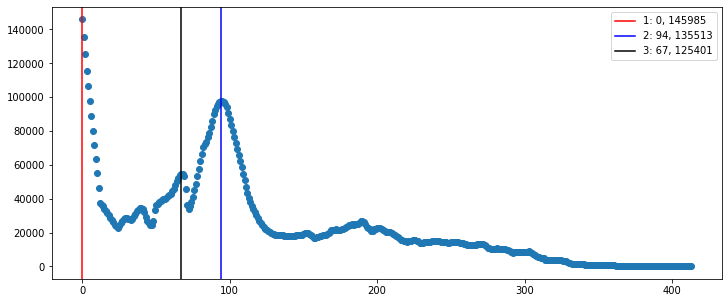

In [15]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
color = ['r', 'b', 'k']

ax.scatter(range(len(levels)), levels, linewidths=1);
for i in range(min([3, len(pers)])):
    ax.axvline(x=pers[i][-1], c=color[i], label='{}: {}, {}'.format(i+1, pers[i][-1], levels[i]))
ax.legend();

Find separate connected components after removing all the soil-related layers

In [55]:
timg = pot[pidx].copy()
timg = timg[ceros].reshape(cerosshape)
soil_level = np.max([x[-1] for x in pers[:3]]) + 3

timg[:soil_level, :, :] = 0

labels,num = ndimage.label(timg, structure=ndimage.generate_binary_structure(raw.ndim, 1))
regions = ndimage.find_objects(labels)
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])

790 [1093674  924535  698467  545575  511888  345084  226904  127678  105782
   20872   14779    7945    1411    1256     790     560     524     506
     477     438]


Consider only the connected components such that they encompass at least 1% of all nonzero voxels

In [56]:
cutoff = 5e-3
sz_hist = np.sum(hist)
struc=ndimage.generate_binary_structure(raw.ndim, 2)
snaps = []

for j in range(len(regions)):
    i = argsort_hist[j]
    r = regions[i]
    if(hist[i]/sz_hist > cutoff):
        mask = labels[r]==i+1
        box = timg[r].copy()
        box[~mask] = 0
        box[box > 0] = 1
        box = ndimage.grey_dilation(box, size=(3,7,7), mode='mirror')
        box = ndimage.grey_dilation(box, size=(3,7,7), mode='mirror')
        
        leaf = rawp[r]*box
        snap = thales.collapse_dimensions(leaf)
        snaps.append(snap[0])

print('Large components: ', len(snaps))

Large components:  9


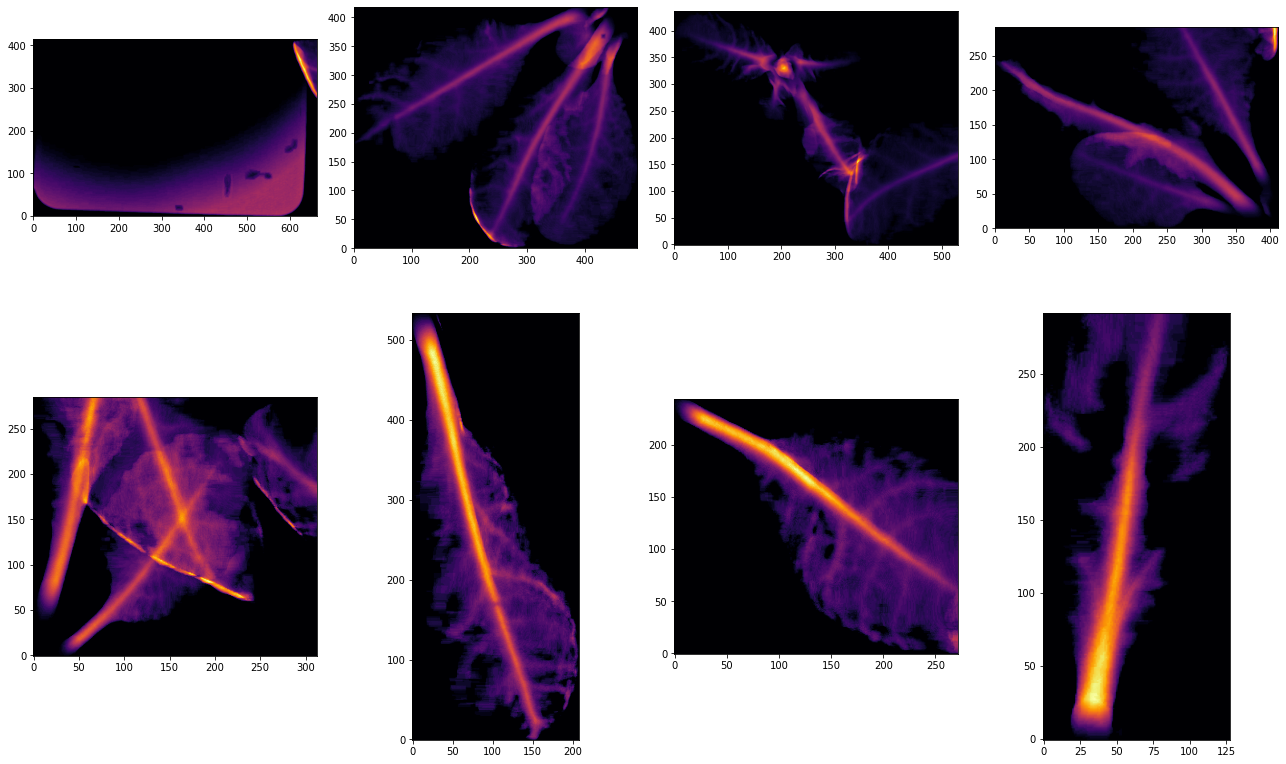

In [59]:
fig, ax = plt.subplots(2,4, figsize=(18,12))

idx = 0
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].imshow(snaps[idx], cmap='inferno', origin='lower');
        idx += 1

fig.tight_layout()
#plt.savefig('separated_leaves_closeup_{}.jpg'.format(pidx), dpi=150, pil_kwargs={'optimize':True})

# Get the whole plant

Renumber the labels so they go from high to low.
- Label `1` corresponds to the largest connected component
- Label `2` corresponds to the second largest connected component
- And so on

In [60]:
npz = np.hstack(([0],1+np.argsort(argsort_hist)))

with np.nditer(labels, flags=['external_loop'], op_flags=['readwrite']) as it:
    for x in it:
        x[...] = npz[x]

- Select only labels that correspond to leaves. Ignore labels that correspond to soil or pot.

In [61]:
struc=ndimage.generate_binary_structure(raw.ndim, 2)

mask = (labels > 1) & (labels < 10) #& (labels != 2)
box = timg.copy()
box[~mask] = 0
box[box > 0] = 1

box = ndimage.grey_dilation(box, size=(3,13,13), mode='mirror')

plant, lceros, lcerosshape = thales.clean_zeroes(rawp*box)
box = box[lceros].reshape(lcerosshape)
#snaps.append(snap[0])

26 % reduction from input


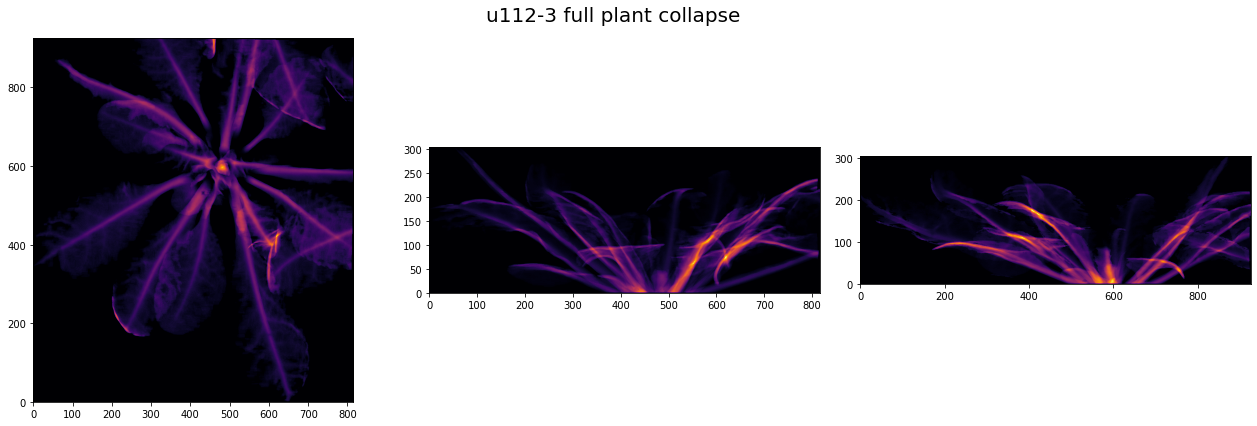

In [62]:
snaps = thales.collapse_dimensions(plant)
thales.plot_collapse_dimensions(snaps, bname, 'full plant', )

In [63]:
coords = thales.tiff2coords(plant, False)
print(coords.shape)

filename = dst + bname + '_pot{}.csv'.format(pidx)
print(filename)
np.savetxt(filename, coords+1, delimiter=',', fmt='%d')

(3554785, 3)
../leaves/u112-3/pot2/u112-3_pot2.csv


# Break up individual leaves (Work in progress)

- Current idea: Remove the rosette center, maybe that separates nicely the rest of leaves.

In [65]:
rosette_center = np.array(np.nonzero(snaps[0] == snaps[0].max())).squeeze()
#rosette_center = np.mean(coords, axis=0)
print(rosette_center)
print(plant.shape)

[421 619]
(305, 926, 816)


In [64]:
cil_dist = np.sqrt((coords[:,1] - rosette_center[0])**2 + (coords[:,2] - rosette_center[1])**2)
cil_dist

array([381.13098085, 381.1795663 , 381.23076866, ..., 881.12634702,
       881.99549264, 882.8649153 ])

In [41]:
cil_size = 50
out_cil = np.zeros(plant.shape, dtype=bool)
out_cil[tuple(coords[cil_dist > cil_size, :].T)] = True

in_cil = np.zeros(plant.shape, dtype=bool)
in_cil[tuple(coords[cil_dist <= cil_size, :].T)] = True

### I need to figure out how to get the rosette in the first place...

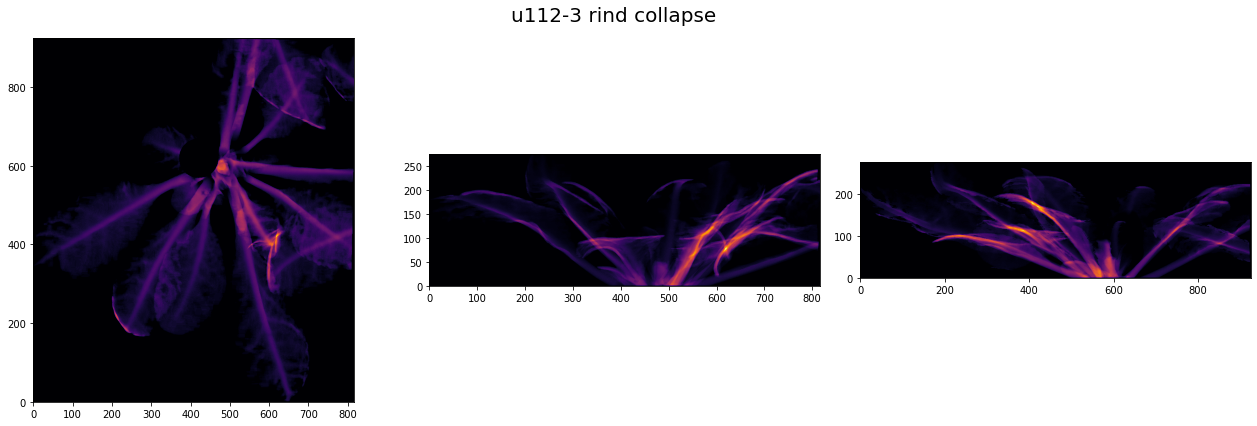

In [42]:
snaps = thales.collapse_dimensions(out_cil)
thales.plot_collapse_dimensions(snaps, bname, 'rind')

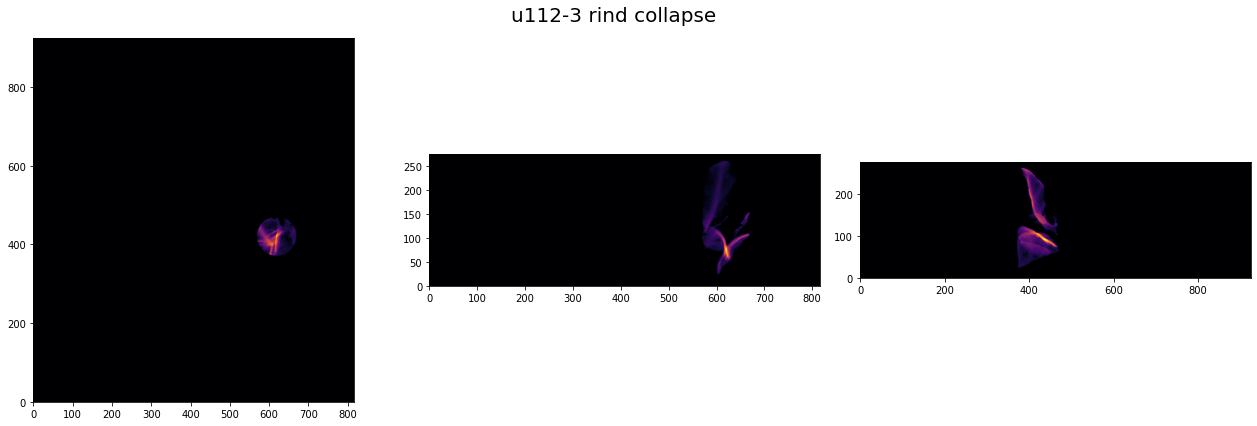

In [33]:
snaps = thales.collapse_dimensions(in_cil)
thales.plot_collapse_dimensions(snaps, bname, 'rind')

In [158]:
filename = dst + bname + '_pot{}_incylinder.csv'.format(pidx)
print(filename)
np.savetxt(filename, thales.tiff2coords(in_cil)+1, delimiter=',', fmt='%d')

../leaves/col-0/pot2/col-0_pot2_incylinder.csv


In [159]:
labels,num = ndimage.label(out_cil, structure=ndimage.generate_binary_structure(raw.ndim, 1))
regions = ndimage.find_objects(labels)
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])

188 [184611 133627 121298  83466  75202  70643  58868  45918   3027     56
     40     25     23     22     21     18     17     16     15     15]


In [160]:
cutoff = 1e-2
sz_hist = np.sum(hist)
struc=ndimage.generate_binary_structure(raw.ndim, 2)
snaps = []

for j in range(len(regions)):
    i = argsort_hist[j]
    r = regions[i]
    if(hist[i]/sz_hist > cutoff):
        mask = labels[r]==i+1
        box = out_cil[r].copy()
        box[~mask] = 0
        box[box > 0] = 1
        #box = ndimage.grey_dilation(box, size=(3,7,7), mode='mirror')
        #box = ndimage.grey_dilation(box, size=(3,7,7), mode='mirror')
        
        leaf = plant[r]*box
        snap = thales.collapse_dimensions(leaf)
        snaps.append(snap[0])
        
        filename = dst + 'leaf_{:02d}.tif'.format(j)
        print(filename)
        tf.imwrite(filename, leaf, photometric='minisblack', compress=3)
        
print('Large components: ', len(snaps))

../leaves/col-0/pot2/leaf_00.tif
../leaves/col-0/pot2/leaf_01.tif
../leaves/col-0/pot2/leaf_02.tif
../leaves/col-0/pot2/leaf_03.tif
../leaves/col-0/pot2/leaf_04.tif
../leaves/col-0/pot2/leaf_05.tif
../leaves/col-0/pot2/leaf_06.tif
../leaves/col-0/pot2/leaf_07.tif
Large components:  8


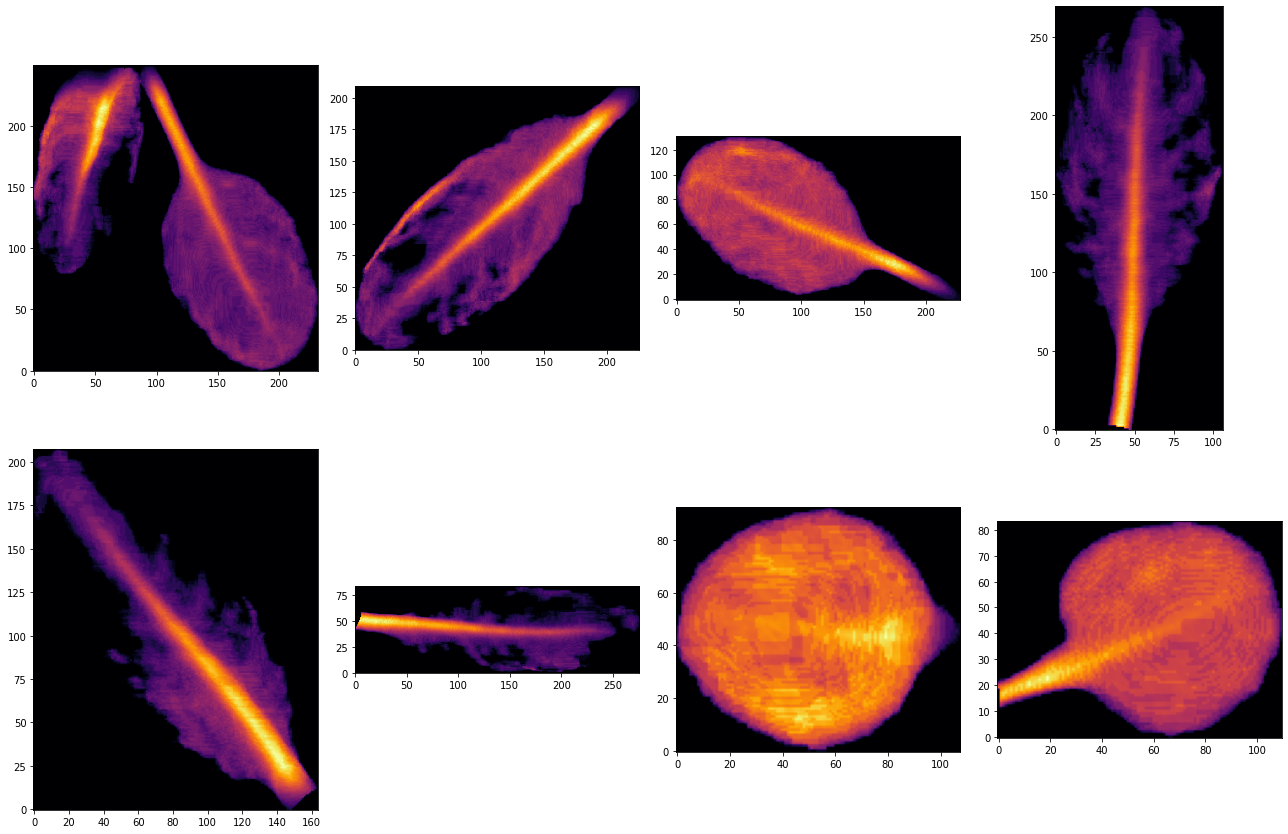

In [161]:
fig, ax = plt.subplots(2,4, figsize=(18,12))

idx = 0
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].imshow(snaps[idx], cmap='inferno', origin='lower');
        idx += 1

fig.tight_layout()
#plt.savefig('separated_leaves_closeup_{}.jpg'.format(pidx), dpi=150, pil_kwargs={'optimize':True})

In [72]:
dtedt = ndimage.distance_transform_edt(leaf)#, metric='taxicab')
maxd = np.max(dtedt)
print(maxd)

36.0


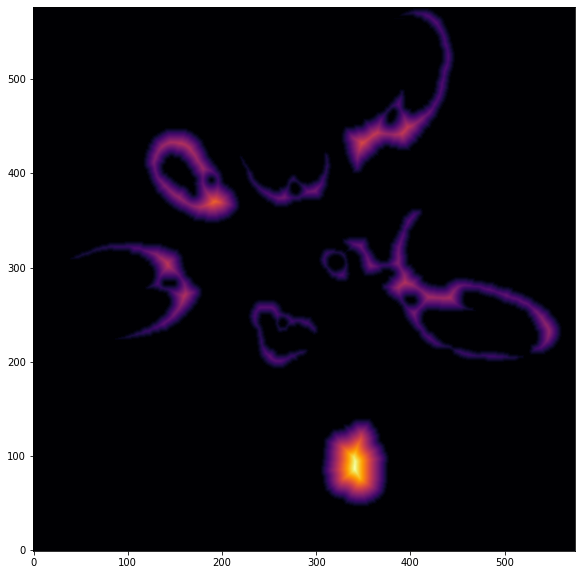

In [79]:
foo = leaf[ss].copy()
foo[foo > 0] = 1
bar = ndimage.distance_transform_edt(foo)
print(bar.max())

plt.figure(figsize=(10,10))
plt.imshow(bar, cmap='inferno', origin='lower');

In [98]:
coords = peak_local_max(bar, footprint=np.ones((3, 3)), labels=foo,
                        min_distance=50, threshold_rel=0.5)
mask = np.zeros(bar.shape, dtype=bool)
mask[tuple(coords.T)] = True
mask = ndimage.binary_dilation(mask, iterations=5)
markers, num = ndimage.label(mask)
print(num, 'components')

5 components


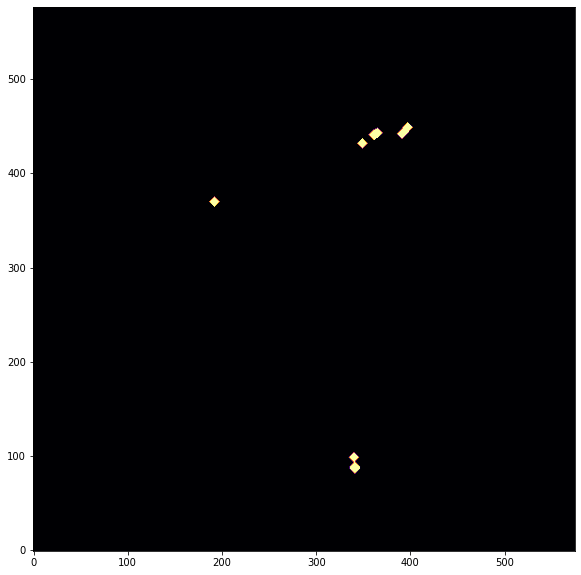

In [99]:
plt.figure(figsize=(10,10))
plt.imshow(mask, cmap='inferno', origin='lower');

In [83]:
coords = peak_local_max(dtedt, min_distance=6,
                        threshold_abs=0.8*maxd, footprint=np.ones((3, 3, 3)), 
                        labels=box, exclude_border=False)
print(coords.shape)
print(coords)

(278, 3)
[[  1 112  86]
 [  1 116  84]
 [  3 117  81]
 [  6 119  73]
 [  6 119  74]
 [  6 120  72]
 [  6 120  73]
 [  6 121  72]
 [  6 122  71]
 [  3 122  75]
 [  3 122  74]
 [  3 121  77]
 [  3 121  76]
 [  3 120  78]
 [  3 120  77]
 [  3 119  78]
 [  3 118  79]
 [  5 120  75]
 [  3 117  80]
 [  3 116  81]
 [  7 118  72]
 [  4 119  77]
 [  4 120  76]
 [  4 121  74]
 [  5 120  74]
 [  5 120  73]
 [  5 119  76]
 [  5 121  74]
 [  5 121  75]
 [  5 122  72]
 [  5 122  73]
 [  5 123  71]
 [  5 123  72]
 [  7 120  71]
 [  4 123  73]
 [  4 123  72]
 [  4 122  75]
 [  4 122  74]
 [  4 122  73]
 [  4 121  76]
 [  4 121  75]
 [  3 112  83]
 [  3 111  84]
 [  5 121  73]
 [  3 110  85]
 [  2 110  87]
 [  2 110  86]
 [  3 110  86]
 [  1 119  81]
 [  1 119  80]
 [  1 118  82]
 [  1 118  81]
 [  1 117  82]
 [  1 114  86]
 [  1 114  85]
 [  1 111  88]
 [  0 119  82]
 [  0 119  81]
 [  0 118  83]
 [  0 118  82]
 [  0 114  86]
 [  0 112  88]
 [  2 112  84]
 [  2 113  84]
 [  1 120  79]
 [  2 119  79]
 

In [88]:
mask = np.zeros(dtedt.shape, dtype=bool)
mask[tuple(coords.T)] = True
#mask = ndimage.binary_dilation(mask, iterations=6)

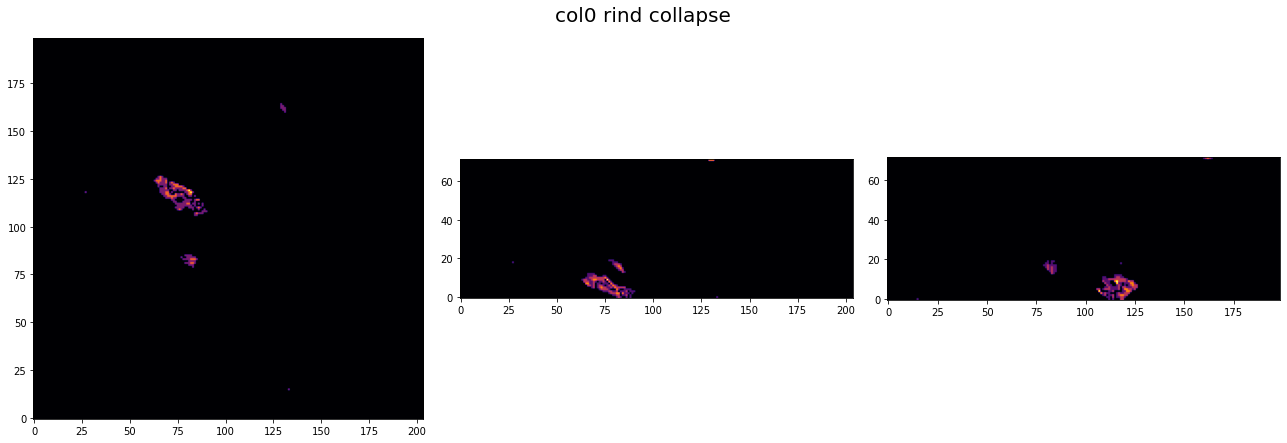

In [89]:
writefig = False
display  = True
diag_dst = src
snaps = thales.collapse_dimensions(mask)
thales.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=writefig, dst=diag_dst)

In [ ]:
writefig = False
display  = True
diag_dst = src
snaps = thales.collapse_dimensions(dtcdt > 8)
thales.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=writefig, dst=diag_dst)

In [ ]:
np.sum(dtcdt > 10 )

In [ ]:
size = (21,5,5)
prod = np.product(np.array(size))

bvg2 = ndimage.uniform_filter(bavg2, size=size, output = float)
bvg2 = (prod*bvg2).astype(np.uint)
print(prod)

In [ ]:
mimg = timg.copy()
mimg[avg < 15] = 0
mimg[bvg < 275] = 0
mimg[bvg2 < 400] = 0

In [ ]:



# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndimage.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, num = ndimage.label(mask)
print(num, 'labels')
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()

In [ ]:
tuple(coords.T)